In [1]:
using Plots
using Base.Iterators
using LinearAlgebra
using LowRankApprox
using TensorOperations

In [2]:
n=3 #positive integer determining the shape
function f(x, a, l)
    return (1 - ((x - a) / l)^2)^n
end
function f_(x, a, l)
    return -n*(1 - ((x - a) / l)^2)^(n-1)*2(x-a)/l^2
end
function f__(x, a, l)
    return 4*(n-1)*n*(x-a)^2*(1 - ((x - a) / l)^2)^(n-2) / l^4  - 2*n*(1 - ((x - a) / l)^2)^(n-1)/l^2
end

f__ (generic function with 1 method)

In [3]:
function ϕ(x)
    ϕx = zeros(length(x),D)
    for i in 1:D
        ϕx[:,i] .= @. f.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i]
    end
    return ϕx
end
function ϕ_(x)
    ϕx = zeros(length(x),D)
    for i in 1:D
        ϕx[:,i] .= @. f_.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i]
    end
    return ϕx
end
function ϕ__(x)
    ϕx = zeros(length(x),D)
    for i in 1:D
        ϕx[:,i] .= @. f__.(mod.(x .+shifts[i], l), l/2, l/2) .* signs[ceil.(Int, (x.+shifts[i])/l), i]
    end
    return ϕx
end

using Statistics
function p(res)
    return res .^2 / mean(res .^2)
end
function wave(res)
    return res /  sqrt(mean(res .^2))
end

wave (generic function with 1 method)

# Some hermitian operators

In [4]:
D,l = 5_000, 0.25

x = collect(range(0,1,length=1000))

signs = rand((-1,1), ceil(Int, 1/l)+1, D)
signs[1,:].=0
signs[end,:].=0
shifts = l * rand(D);

In [5]:
ϕx = ϕ(x);
ϕx_ = ϕ_(x);
ϕx__ = ϕ__(x);

ϕy = circshift(ϕx, (0,1))
ϕy_ = circshift(ϕx_, (0,1))
ϕy__ = circshift(ϕx__, (0,1))
            
ϕz = circshift(ϕx, (0,2))
ϕz_ = circshift(ϕx_, (0,2))
ϕz__ = circshift(ϕx__, (0,2));

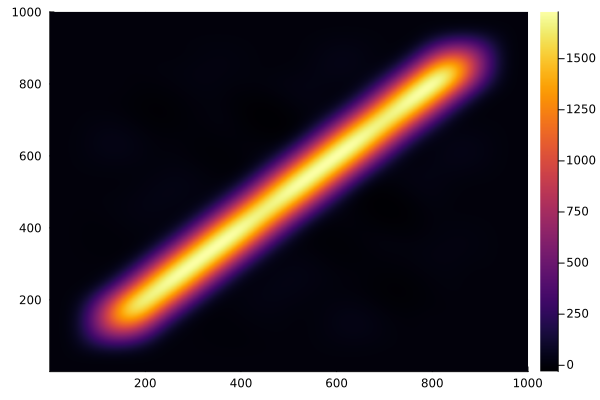

In [6]:
heatmap(ϕx*ϕx')

kinetic energy: $- \frac{\hbar^2}{2m} \nabla^2$

In [7]:
K = - (ϕx' * ϕx__ + ϕy' * ϕy__ + ϕz' * ϕz__) / length(x);

coulomb potential

In [8]:
function coulomb(x,y,z)
    return -1/(sqrt((x-0.5)^2+(y-0.5)^2+(z-0.5)^2))
end

coulomb (generic function with 1 method)

In [9]:
function calcV(r)
    rind = 1:length(r)
    s = product(r,r,r)
    sind = product(rind, rind, rind)

    ϕxr = ϕ(r)
    ϕyr = circshift(ϕxr, (0,1))
    ϕzr = circshift(ϕxr, (0,2));
    
    Pot = zeros(length(r),length(r),length(r))
    for ((x,y,z), (i,j,k)) in zip(s, sind)
        Pot[i,j,k] = coulomb(x,y,z)
    end
    
    D3 = zeros(length(r), length(r), length(r), D)
    for (i,j,k) in sind
        D3[i,j,k,:] .= @. ϕxr[i,:] .* ϕyr[j,:] .* ϕzr[k,:]
    end
    #PotD3 = Pot .* D3
    @tensor V[a,b] := D3[i,j,k,a]*(Pot .* D3)[i,j,k,b];
    return V
end 

calcV (generic function with 1 method)

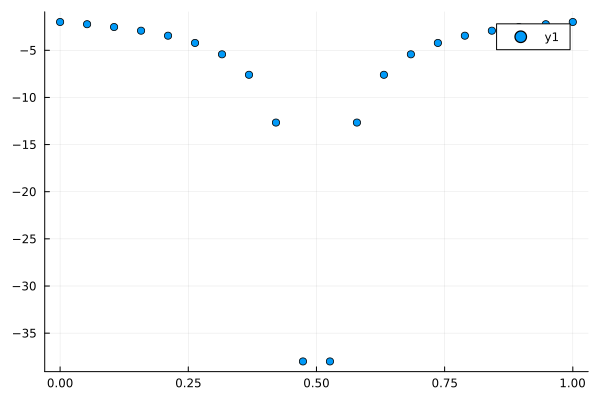

In [10]:
m=20
r1 = collect(range(0,1,length=m))
scatter(r1, -1 ./abs.(0.5.-r1))

In [11]:
V = calcV(r1);

# The hamiltonian operator

putting $\frac{\hbar^2}{2m} = 1$ and $\frac{1}{2}m\omega^2=10^5$

In [12]:
H1 = K / maximum(K)
H2 = V/maximum(V);

In [13]:
H = H1 + H2;
H = (H .+ H')/2;
size(H)

(5000, 5000)

In [14]:
@time E, Ψ = eigen(H) ;
size(E), size(Ψ)

 19.380674 seconds (1.32 M allocations: 650.209 MiB, 0.80% gc time, 3.11% compilation time)


((5000,), (5000, 5000))

In [15]:
r=range(0,1,length=100)

ϕxr = ϕ(r)
ϕyr = circshift(ϕxr, (0,1))
ϕzr = circshift(ϕxr, (0,2));

function plotslice(Ψ,title)
    res=zeros(length(r), length(r))
    for i in 1:length(r)
        for j in 1:length(r)
            res[i,j] = (mean(Ψ .* ϕx[500,:] .* ϕyr[i,:] .* ϕzr[j,:]))
        end
    end
    max_val = maximum(abs.(res))
    heatmap(res, c=:broc,  clims=(-max_val, max_val), colorbar=false,xticks=false, yticks=false,axis=false, title=title)
end

plotslice (generic function with 1 method)

In [16]:
p1 = plotslice(Ψ[:,1], "E1")
p2 = plotslice(Ψ[:,2], "E2")
p3 = plotslice(Ψ[:,3], "E3")
p4 = plotslice(Ψ[:,4], "E4")
p5 = plotslice(Ψ[:,5], "E5")
p6 = plotslice(Ψ[:,6], "E6");

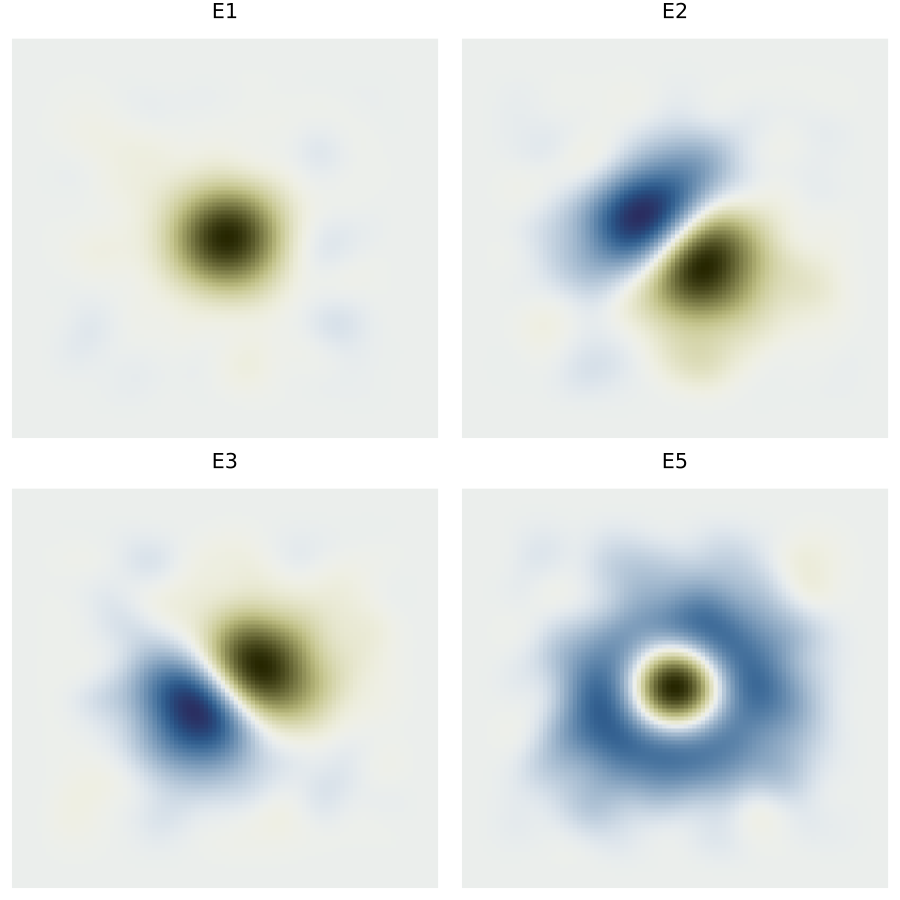

In [22]:
pl = plot(p1,p2,p3,p5, layout = (2,2), size=(900,900) )

In [23]:
savefig(pl,"solutionhydrogen.png")